# Implementation of simple regression using Tenforflow probability 
* Classic regression 
* Flipout regression 
* Gaussian Likelihood regression
* Gaussian Likelihood + Flipout layers 

In [1]:
import numpy as np 
import tensorflow_probability as tfp 
import matplotlib.pyplot as plt 
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import tqdm 

sns.set()
tfd = tfp.distributions
tfk = tf.keras 

# Start to generate the dataset 

In [2]:
# regression using MCMC sampling 
NUM_TRAIN_EXAMPLES = 100000
x = np.linspace(0,100,NUM_TRAIN_EXAMPLES)
y_clean = x/100*np.sin(x/2) 
array_std = .5/100*x
y = y_clean + np.random.normal(0,array_std,len(x))

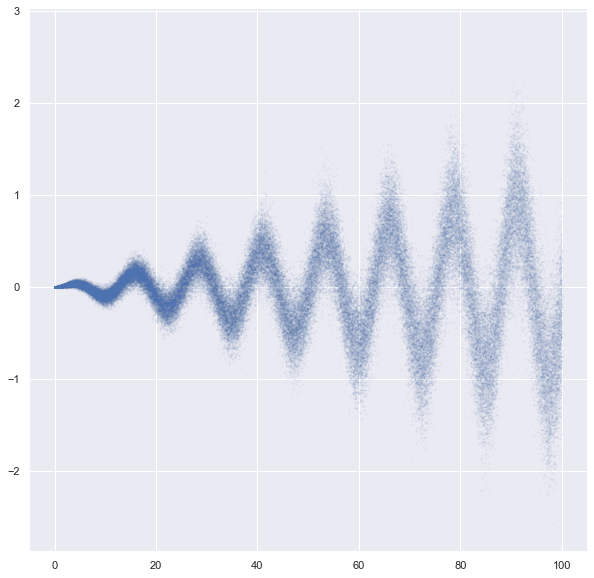

In [3]:
plt.figure(figsize=(10,10))

plt.scatter(x,y,alpha=.05,s=1)

In [4]:
# utility for tensorflow 

class CustomCallback(tfk.callbacks.Callback):
    def __init__(self, print_n_epochs=1000):
        super(CustomCallback, self).__init__()
        self.print_n_epochs = print_n_epochs
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch%self.print_n_epochs==0:
            try:
                print(f"Epoch {epoch} loss : {logs['loss']:.2f}, mse :{logs['mean_squared_error']:.2f}")
            except:
                print(f"Epoch {epoch} loss : {logs['loss']:.2f}")
                
class LrReducer(tfk.callbacks.Callback):
    def __init__(self, patience=0, reduce_rate=0.5, reduce_nb=100, verbose=1):
        super(Callback, self).__init__()
        self.patience = patience
        self.wait = 0
        self.best_score = -1.
        self.reduce_rate = reduce_rate
        self.current_reduce_nb = 0
        self.reduce_nb = reduce_nb
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current_score = logs.get('val_acc')
        if current_score > self.best_score:
            self.best_score = current_score
            self.wait = 0
            if self.verbose > 0:
                print('---current best val accuracy: %.3f' % current_score)
        else:
            if self.wait >= self.patience:
                self.current_reduce_nb += 1
                if self.current_reduce_nb <= self.reduce_nb:
                    lr = self.model.optimizer.lr.get_value()
                    self.model.optimizer.lr.set_value(lr*self.reduce_rate)
                else:
                    if self.verbose > 0:
                        print("Epoch %d: early stopping" % (epoch))
                    self.model.stop_training = True
            self.wait += 1
            

In [5]:
# Function usedd for the bayesian inference 

# taken from the tf2 examples 
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                            tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

# here py is the distribution parametrized by the neural network 
# y in the drawn example 
neg_log_like = lambda y, p_y: -tf.reduce_sum(p_y.log_prob(y))

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(  # pylint: disable=g-long-lambda
          tfd.Normal(loc=.5*t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + .5*t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(
          lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1),  # pylint: disable=g-long-lambda
                                    reinterpreted_batch_ndims=1)),
  ])


# Simple regression 

In [6]:
# simple point regression

try:
    del model 
    print('model deleted')
except:
    pass


model = tf.keras.Sequential([
  tf.keras.layers.Dense(8,
                       activation='elu'),
  tf.keras.layers.Dense(8,
                       activation='elu'),
  tf.keras.layers.Dense(8,
                       activation='elu'),
  tf.keras.layers.Dense(8,
                       activation='elu'),
  tf.keras.layers.Dense(1),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-3),
              loss='mse',
              metrics =[tfk.metrics.MeanSquaredError()],
)

In [7]:
# Do inference.
history= model.fit(x, y, epochs=10000,
          batch_size=10000, 
          callbacks=[CustomCallback(1000)],
          verbose=0)

Epoch 0 loss : 4.81, mse :4.81
Epoch 1000 loss : 0.16, mse :0.16
Epoch 2000 loss : 0.13, mse :0.13
Epoch 3000 loss : 0.09, mse :0.09
Epoch 4000 loss : 0.09, mse :0.09
Epoch 5000 loss : 0.09, mse :0.09
Epoch 6000 loss : 0.09, mse :0.09
Epoch 7000 loss : 0.09, mse :0.09
Epoch 8000 loss : 0.09, mse :0.09
Epoch 9000 loss : 0.09, mse :0.09


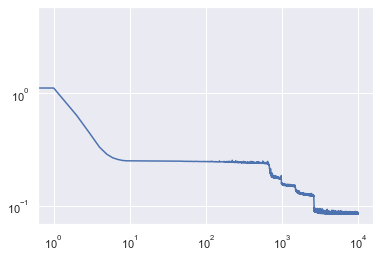

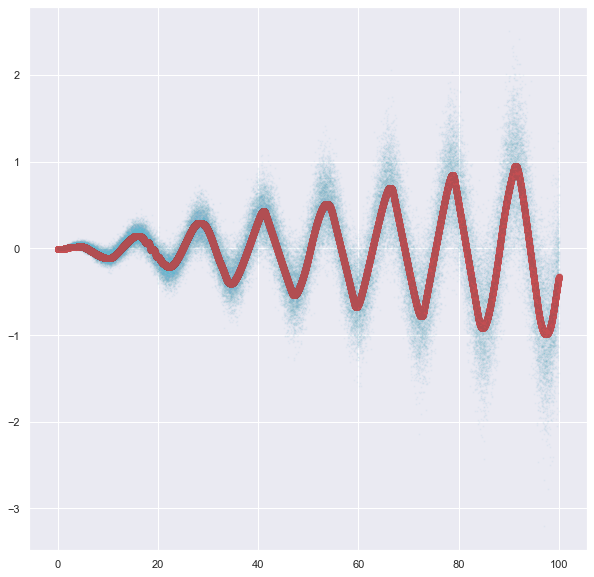

In [8]:
yhat = model.predict(x)

# plot history
plt.plot(history.history['loss'])
plt.yscale('log')
plt.xscale('log')
# plot 
plt.figure(figsize=(10,10))
plt.scatter(x,y,alpha=.05,s=1,c='c',label='data')
plt.scatter(x,yhat,c='r',alpha=.05,label = 'pred')

# Monte carlo Flipout layers  only
based on the following paper : 
https://arxiv.org/pdf/1803.04386.pdf

In [34]:

try:
    del model 
    print('model deleted')
except:
    pass

# using the flipout estimator 
# model = tf.keras.Sequential([
#   tfp.layers.DenseFlipout(8,
#                           #kernel_divergence_fn=kl_divergence_function,
#                        activation='tanh'),
#   tfp.layers.DenseFlipout(8,
#                           #kernel_divergence_fn=kl_divergence_function,
#                        activation='elu'),
#   tfp.layers.DenseFlipout(1,
#                          #kernel_divergence_fn=kl_divergence_function,
#                          ),
#   tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=.5))
# ])


# using dense variationnal with mean field approximation 
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(8,
                              posterior_mean_field,
                              prior_trainable,
                              activation='elu',
                              kl_weight=10000/NUM_TRAIN_EXAMPLES), # weight is the coeff by batch
  tfp.layers.DenseVariational(8,
                              posterior_mean_field,
                              prior_trainable,
                              activation='elu',
                              kl_weight=10000/NUM_TRAIN_EXAMPLES),
  tfp.layers.DenseVariational(8,
                              posterior_mean_field,
                              prior_trainable,
                              activation='elu',
                              kl_weight=10000/NUM_TRAIN_EXAMPLES),
  tfp.layers.DenseVariational(8,
                              posterior_mean_field,
                              prior_trainable,
                              activation='elu',
                              kl_weight=10000/NUM_TRAIN_EXAMPLES),
  tfp.layers.DenseVariational(1,
                              posterior_mean_field,
                              prior_trainable,
                              activation='relu',
                              kl_weight=10000/NUM_TRAIN_EXAMPLES), 
    
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=.01))
])

# Do inference.
model.compile(optimizer=tf.optimizers.Nadam(learning_rate=5e-3),
              metrics =[tfk.metrics.MeanSquaredError()],
              loss=neg_log_like)

model deleted


In [35]:
# Do inference.

history= model.fit(x, y, epochs=10000,
          batch_size=10000, 
          callbacks=[CustomCallback(1000)],
          verbose=0)

Epoch 0 loss : 14304216627648.70, mse :286084.31
Epoch 1000 loss : 4065928675.90, mse :81.32
Epoch 2000 loss : 1260729334.40, mse :25.22
Epoch 3000 loss : 12582004.60, mse :0.25
Epoch 4000 loss : 12582005.30, mse :0.25
Epoch 5000 loss : 12582005.60, mse :0.25
Epoch 6000 loss : 12582005.80, mse :0.25
Epoch 7000 loss : 12582005.70, mse :0.25
Epoch 8000 loss : 12582006.30, mse :0.25
Epoch 9000 loss : 12582006.70, mse :0.25


In [ ]:
# plot history
plt.plot(history.history['loss'])
# plt.yscale('log')
# plt.xscale('log')

# plot 
plt.figure(figsize=(10,10))
plt.scatter(x,y,c='c',alpha=.05,s=1)

# draw samples from the trained network 
preds = np.asarray([model.predict(x,batch_size=10000) for i in range(100)])

preds_mean =preds.mean(axis=0)
preds_std = preds.std(axis=0)



plt.scatter(x,preds_mean,c='r',alpha=.5,s=1)
# plt.scatter(x,preds_mean-preds_std,c='g',alpha=.5,s=1)
# plt.scatter(x,preds_mean+preds_std,c='g',alpha=.5,s=1)

# # # original data 
plt.plot(x,y_clean,linewidth=1,c='k')
plt.plot(x,y_clean-array_std,linewidth=1,c='k')
plt.plot(x,y_clean+array_std,linewidth=1,c='k')

# Log-Likelihood maximisation model, without any priors on the weights 

In [10]:
# maximisation of the likelyhood

try:
    del model 
    print('model deleted')
except:
    pass

model = tf.keras.Sequential([
  tf.keras.layers.Dense(8,
                       activation='elu'),
  tf.keras.layers.Dense(8,
                       activation='elu'),
  tf.keras.layers.Dense(8,
                       activation='elu'),
  tf.keras.layers.Dense(8,
                       activation='elu'),
  tf.keras.layers.Dense(8,
                       activation='elu'),
  tf.keras.layers.Dense(2),
  tfp.layers.DistributionLambda(
  lambda t: tfd.Normal(loc=t[..., :1],
                       scale=1e-6 + tf.math.softplus(0.05 * t[..., 1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-3),
              metrics =[tfk.metrics.MeanSquaredError()],
              loss=neg_log_like)

model deleted


In [11]:
history= model.fit(x, y, epochs=10000,
          batch_size=10000,
          callbacks = [CustomCallback(print_n_epochs=1000)],
          verbose=0)

Epoch 0 loss : 57946.72, mse :4.63
Epoch 1000 loss : -284.46, mse :0.33
Epoch 2000 loss : -849.47, mse :0.29
Epoch 3000 loss : -1005.88, mse :0.26
Epoch 4000 loss : -1231.91, mse :0.25
Epoch 5000 loss : -1272.88, mse :0.24
Epoch 6000 loss : -1800.99, mse :0.18
Epoch 7000 loss : -2461.17, mse :0.17
Epoch 8000 loss : -2365.96, mse :0.17
Epoch 9000 loss : -2474.16, mse :0.17



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



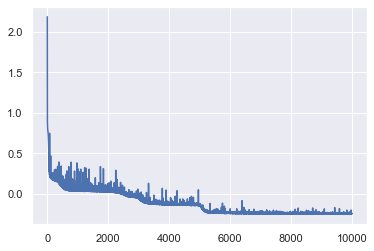

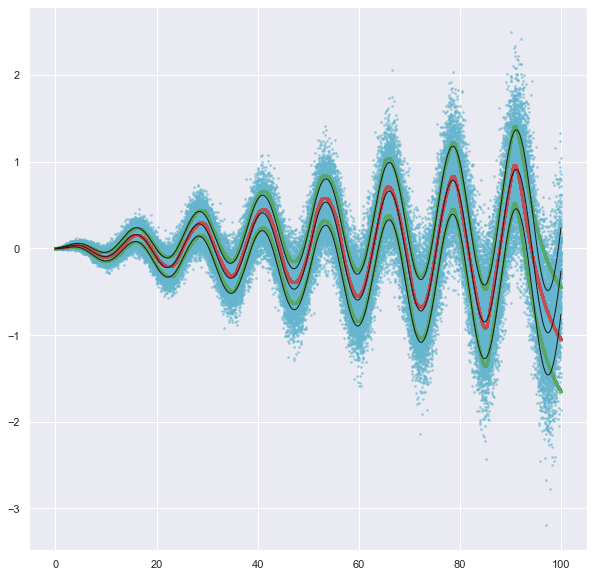

In [14]:
yhat = model(x.reshape(-1,1))
# plot history
plt.plot(history.history['loss'],label='neglogloss')


# original data 
plt.figure(figsize=(10,10))

plt.scatter(x,y,c='c',alpha=.5,s=3,label='noisy data')
plt.plot(x,y_clean,linewidth=1,c='k',label='original data')
plt.plot(x,y_clean-array_std,linewidth=1,c='k',label='data-std')
plt.plot(x,y_clean+array_std,linewidth=1,c='k',label='data+std')

# plot 
plt.scatter(x,yhat.mean()+yhat.stddev(),c='g',alpha=.5,s=3, label = 'mean_pred+std')
plt.scatter(x,yhat.mean()-yhat.stddev(),c='g',alpha=.5,s=3,label ='mean_pred-std')
plt.scatter(x,yhat.mean(),c='r',alpha=.5,s=3,label='mean_pred')

# Log-likelihood with priors on the weights (using Flipout estimator )

In [15]:
# maximisation of the likelyhood with gaussian prior 

tfk.backend.clear_session()

try:
    del model 
    print('model deleted')
except:
    pass

tfk.backend.set_floatx('float32')

model = tf.keras.Sequential([
  tfp.layers.DenseFlipout(32,
                          kernel_divergence_fn=kl_divergence_function,
                       activation='tanh'),
  tfk.layers.BatchNormalization(),
  tfp.layers.DenseFlipout(32,
                          kernel_divergence_fn=kl_divergence_function,
                       activation='tanh'),
  tfk.layers.BatchNormalization(),
  tfp.layers.DenseFlipout(32,
                          kernel_divergence_fn=kl_divergence_function,
                       activation='tanh'),
  tfk.layers.BatchNormalization(),
    
  tfp.layers.DenseFlipout(32,
                          kernel_divergence_fn=kl_divergence_function,
                       activation='tanh'),
  tfk.layers.BatchNormalization(),
  tfp.layers.DenseFlipout(32,
                          kernel_divergence_fn=kl_divergence_function,
                       activation='tanh'),
  tfk.layers.BatchNormalization(),
    
  tfp.layers.DenseFlipout(2,
                         kernel_divergence_fn=kl_divergence_function),
  tfp.layers.DistributionLambda(
  lambda t: tfd.Normal(loc=t[..., :1],
                       scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:]))),
])

# # Do inference.
# lr = tfk.experimental.CosineDecayRestarts(
#     1e-2, 10000, t_mul=2.0, m_mul=1.0, alpha=1e-2,
#     name=None
# )
model.compile(optimizer=tf.optimizers.Nadam(learning_rate=1e-3),
              loss=neg_log_like,
              metrics =[tfk.metrics.MeanSquaredError()])

model deleted


In [16]:
# history= model.fit(x, y, epochs=100000,
#               batch_size=10000,
#               callbacks = [CustomCallback(10000)],
#               verbose=0)

# # plot history
# plt.figure(figsize=(20,10))
# plt.subplot(1,2,1)
# plt.plot(history.history['loss'])
# #     plt.yscale('log')
# #     plt.xscale('log')
# plt.title('loss')

# # original data 
# plt.subplot(1,2,2)
# plt.scatter(x,y,c='c',alpha=.5,s=3)
# plt.plot(x,y_clean,linewidth=.5,c='k')
# plt.plot(x,y_clean-array_std,linewidth=1,c='k')
# plt.plot(x,y_clean+array_std,linewidth=1,c='k')

# # plot 
# plt.scatter(x,preds_avg.mean(axis=0)+preds_std.mean(axis=0),c='g',alpha=.5,s=3)
# plt.scatter(x,preds_avg.mean(axis=0)-preds_std.mean(axis=0),c='g',alpha=.5,s=3)
# plt.scatter(x,preds_avg.mean(axis=0),c='r',alpha=.5,s=3)
# plt.title('fitted results')
# plt.show()

Epoch 0 loss : 1.45, mse :1.25
Epoch 100 loss : 0.83, mse :0.70
Epoch 200 loss : 0.64, mse :0.53
Epoch 300 loss : 0.52, mse :0.50
Epoch 400 loss : 0.42, mse :0.50
Epoch 500 loss : 0.33, mse :0.49
Epoch 600 loss : 0.27, mse :0.48
Epoch 700 loss : 0.23, mse :0.46
Epoch 800 loss : 0.15, mse :0.46
Epoch 900 loss : 0.07, mse :0.40
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_flipout (DenseFlipout) multiple                  96        
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_flipout_1 (DenseFlipou multiple                  2080      
_________________________________________________________________
batch_normalization_1 (Batch multiple                  128       
__________________________________________________________

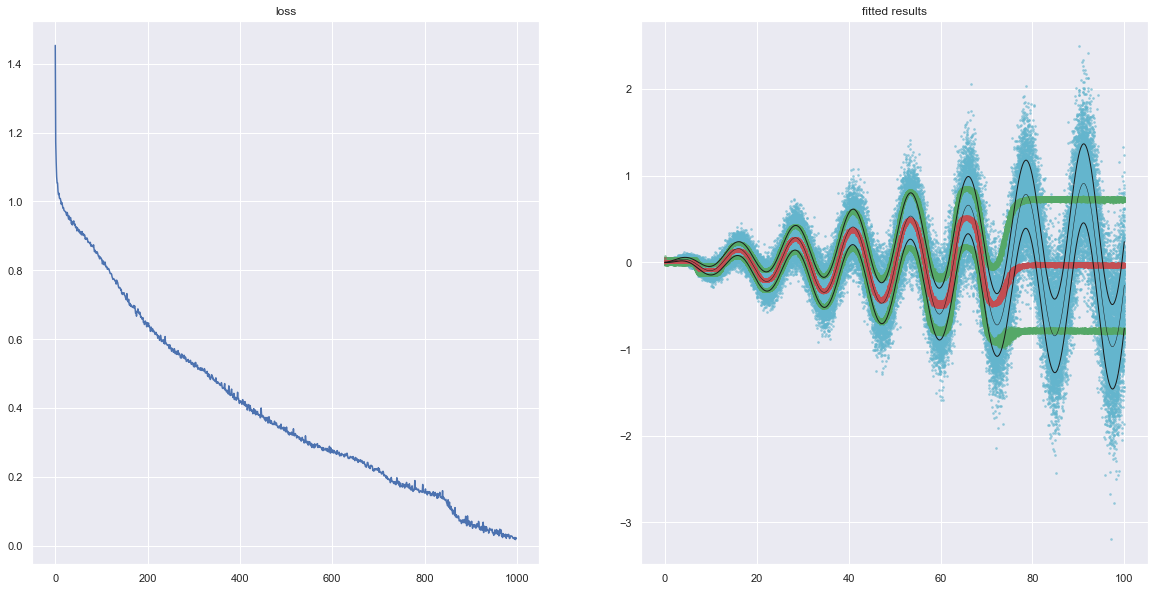

Epoch 0 loss : 0.02, mse :0.38
Epoch 100 loss : -0.01, mse :0.35
Epoch 200 loss : -0.03, mse :0.33
Epoch 300 loss : -0.05, mse :0.32
Epoch 400 loss : -0.05, mse :0.32
Epoch 500 loss : -0.06, mse :0.32
Epoch 600 loss : -0.06, mse :0.32
Epoch 700 loss : -0.07, mse :0.32
Epoch 800 loss : -0.08, mse :0.31
Epoch 900 loss : -0.06, mse :0.32

Model loss and fitting after 2000 epochs :



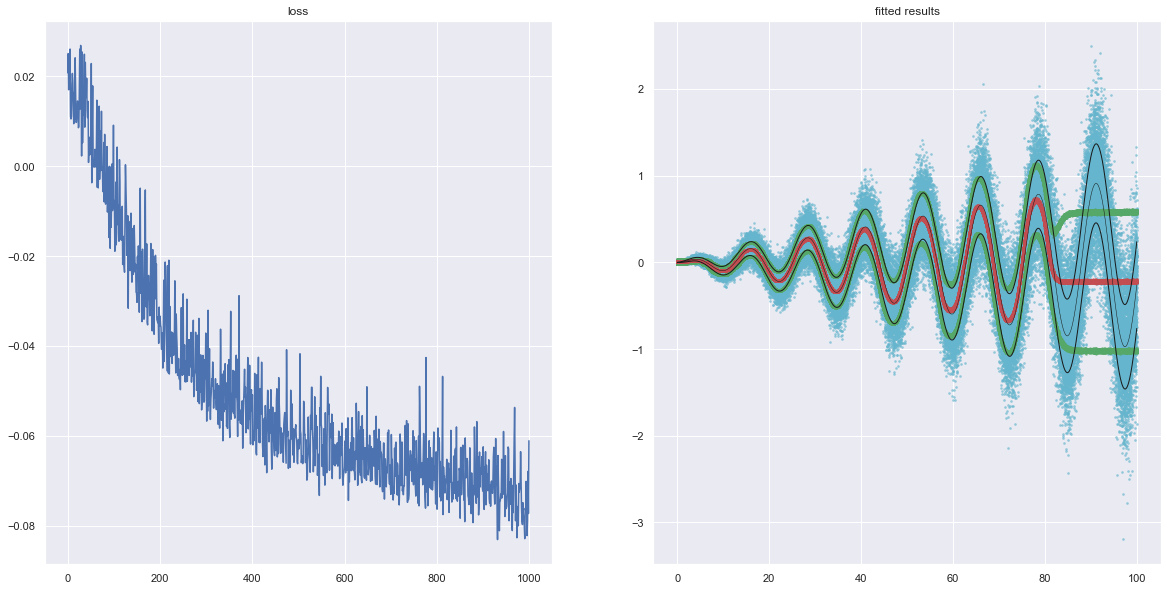

Epoch 0 loss : -0.08, mse :0.31
Epoch 100 loss : -0.10, mse :0.29
Epoch 200 loss : -0.12, mse :0.29
Epoch 300 loss : -0.11, mse :0.29
Epoch 400 loss : -0.12, mse :0.28
Epoch 500 loss : -0.11, mse :0.29
Epoch 600 loss : -0.12, mse :0.29
Epoch 700 loss : -0.10, mse :0.28
Epoch 800 loss : -0.12, mse :0.29
Epoch 900 loss : -0.13, mse :0.28

Model loss and fitting after 3000 epochs :



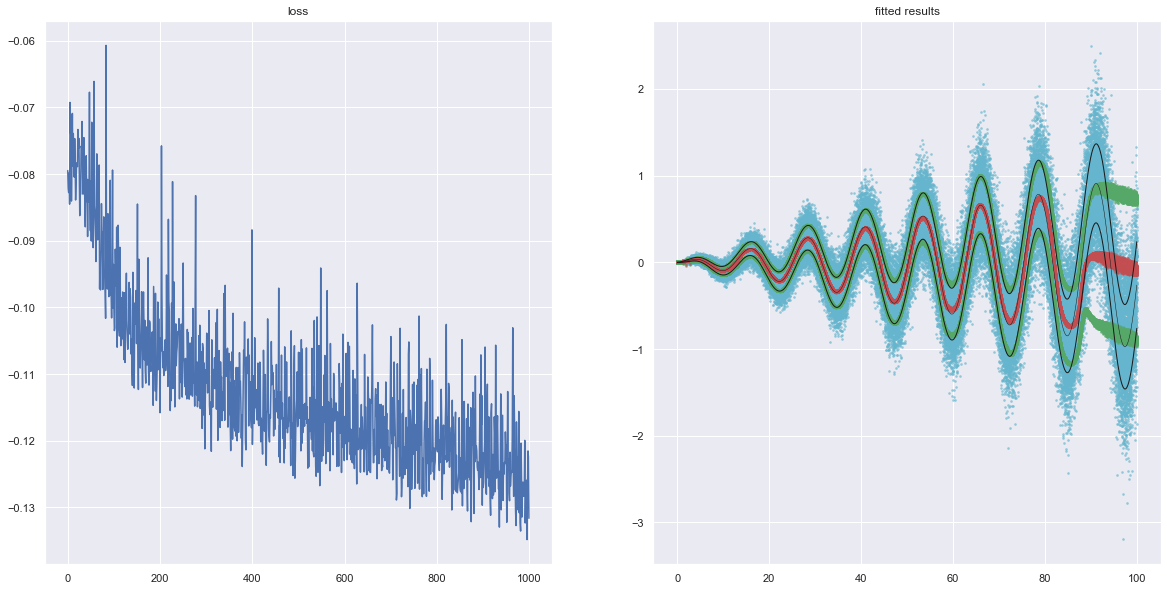

Epoch 0 loss : -0.11, mse :0.27
Epoch 100 loss : -0.15, mse :0.22
Epoch 200 loss : -0.17, mse :0.19
Epoch 300 loss : -0.17, mse :0.19
Epoch 400 loss : -0.17, mse :0.18
Epoch 500 loss : -0.19, mse :0.18
Epoch 600 loss : -0.18, mse :0.18
Epoch 700 loss : -0.18, mse :0.18
Epoch 800 loss : -0.19, mse :0.18
Epoch 900 loss : -0.18, mse :0.18

Model loss and fitting after 4000 epochs :



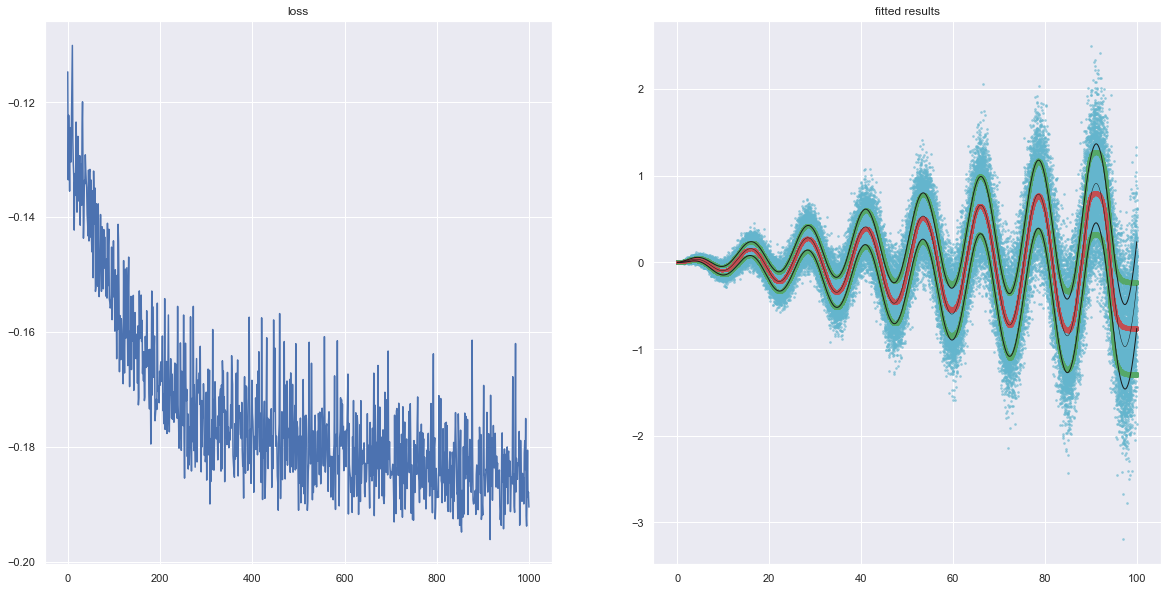

Epoch 0 loss : -0.19, mse :0.18
Epoch 100 loss : -0.18, mse :0.18
Epoch 200 loss : -0.19, mse :0.18
Epoch 300 loss : -0.19, mse :0.18
Epoch 400 loss : -0.19, mse :0.18
Epoch 500 loss : -0.19, mse :0.18
Epoch 600 loss : -0.19, mse :0.18
Epoch 700 loss : -0.19, mse :0.18
Epoch 800 loss : -0.20, mse :0.18
Epoch 900 loss : -0.18, mse :0.18

Model loss and fitting after 5000 epochs :



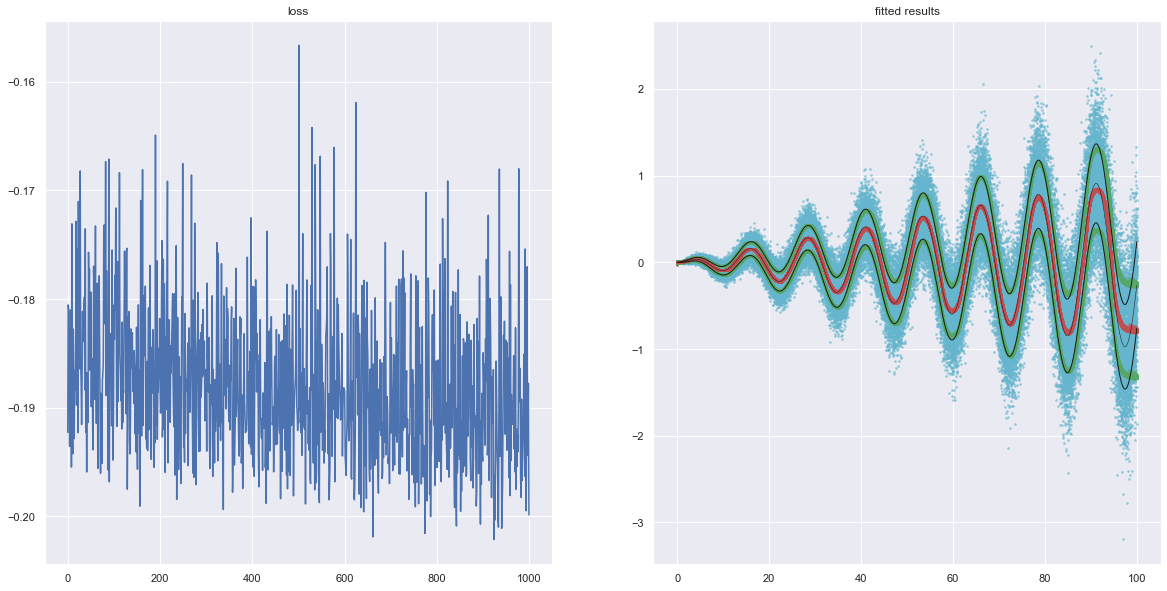

Epoch 0 loss : -0.19, mse :0.18
Epoch 100 loss : -0.20, mse :0.18
Epoch 200 loss : -0.19, mse :0.18
Epoch 300 loss : -0.20, mse :0.18
Epoch 400 loss : -0.19, mse :0.18
Epoch 500 loss : -0.19, mse :0.18
Epoch 600 loss : -0.19, mse :0.18
Epoch 700 loss : -0.19, mse :0.18
Epoch 800 loss : -0.20, mse :0.18
Epoch 900 loss : -0.20, mse :0.18

Model loss and fitting after 6000 epochs :



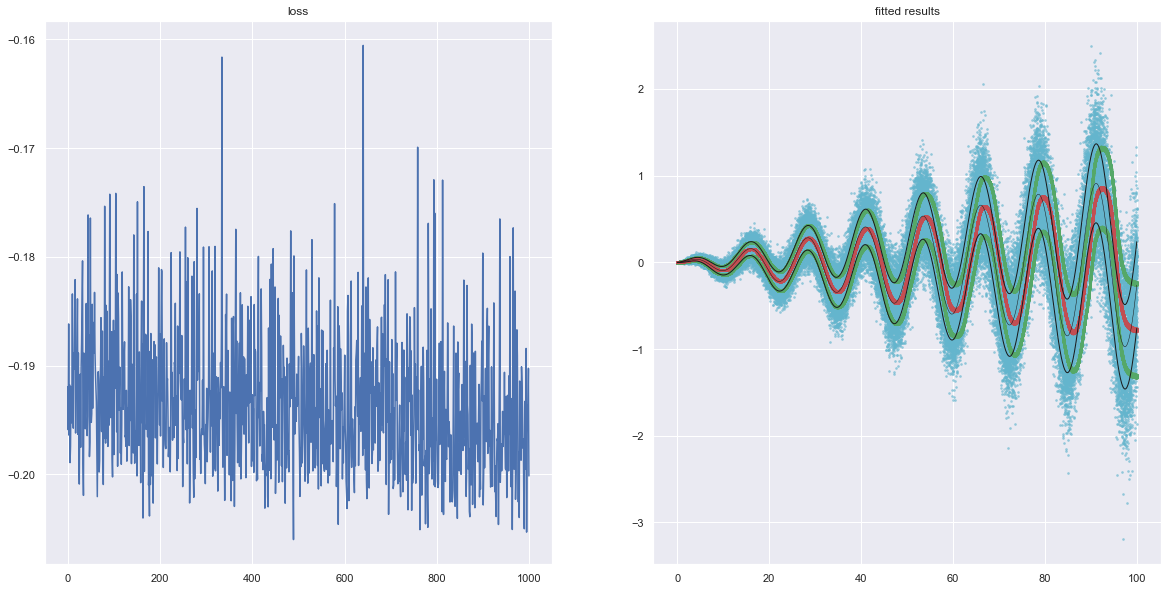

Epoch 0 loss : -0.19, mse :0.18
Epoch 100 loss : -0.19, mse :0.18
Epoch 200 loss : -0.20, mse :0.18
Epoch 300 loss : -0.19, mse :0.18
Epoch 400 loss : -0.19, mse :0.18
Epoch 500 loss : -0.20, mse :0.18
Epoch 600 loss : -0.19, mse :0.18
Epoch 700 loss : -0.19, mse :0.18
Epoch 800 loss : -0.20, mse :0.18
Epoch 900 loss : -0.21, mse :0.18

Model loss and fitting after 7000 epochs :



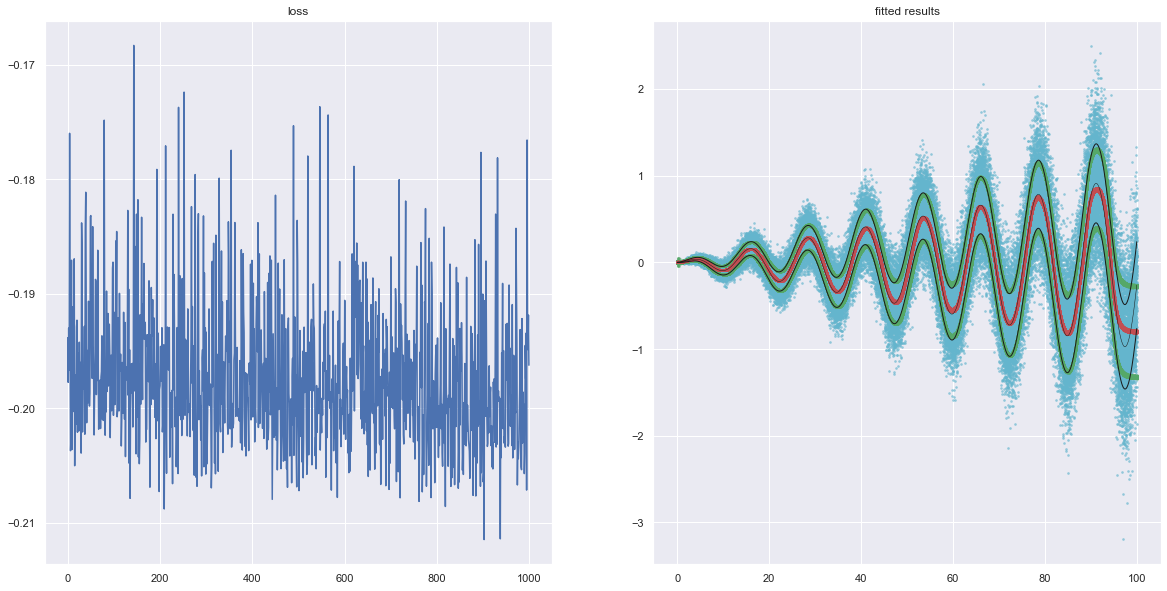

Epoch 0 loss : -0.20, mse :0.18
Epoch 100 loss : -0.20, mse :0.18
Epoch 200 loss : -0.20, mse :0.18
Epoch 300 loss : -0.21, mse :0.18
Epoch 400 loss : -0.21, mse :0.18
Epoch 500 loss : -0.19, mse :0.18
Epoch 600 loss : -0.20, mse :0.18
Epoch 700 loss : -0.20, mse :0.18
Epoch 800 loss : -0.20, mse :0.18
Epoch 900 loss : -0.21, mse :0.18


In [ ]:
# show the learning process 

n_epochs = 1000 
for i in range(10):
    history= model.fit(x, y, epochs=n_epochs,
              batch_size=10000,
              callbacks = [CustomCallback(n_epochs/10)],
              verbose=0)
    
    if i==0:
        print(model.summary()) # as the model is subclasssed and is not a static graph 

    # draw samples (slow in the list comprehension for strange reasons)
    preds_avg = np.asarray([model(x.reshape(-1,1)).mean() for i in range(10)])
    preds_std = np.asarray([model(x.reshape(-1,1)).stddev() for i in range(10)])

    print()
    print(f'Model loss and fitting after {n_epochs*(i+1)} epochs :')
    print()
    
    # plot history
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
#     plt.yscale('log')
#     plt.xscale('log')
    plt.title('loss')

    # original data 
    plt.subplot(1,2,2)
    plt.scatter(x,y,c='c',alpha=.5,s=3)
    plt.plot(x,y_clean,linewidth=.5,c='k')
    plt.plot(x,y_clean-array_std,linewidth=1,c='k')
    plt.plot(x,y_clean+array_std,linewidth=1,c='k')

    # plot 
    plt.scatter(x,preds_avg.mean(axis=0)+preds_std.mean(axis=0),c='g',alpha=.5,s=3)
    plt.scatter(x,preds_avg.mean(axis=0)-preds_std.mean(axis=0),c='g',alpha=.5,s=3)
    plt.scatter(x,preds_avg.mean(axis=0),c='r',alpha=.5,s=3)
    plt.title('fitted results')
    plt.show()
    